## Step 1: Load and briefly inspect the Boston Housing dataset

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from pathlib import Path
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import root_mean_squared_error, r2_score


In [34]:
# Step 1: Load and briefly inspect the Boston Housing dataset

# File path 
path = "../data/HousingData.csv"

# Load dataset
df = pd.read_csv(path)

# Basic overview
print("Shape (rows, cols):", df.shape)
print("\nColumns:\n", list(df.columns))
print("\nDtypes:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))

print("\nNumeric summary:")
print(df.describe().T)

print("\nPreview (first 10 rows):")
display(df.head(10))


Shape (rows, cols): (506, 14)

Columns:
 ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

Dtypes:
CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX          int64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

Missing values per column:
CRIM       20
ZN         20
INDUS      20
CHAS       20
AGE        20
LSTAT      20
NOX         0
RM          0
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
MEDV        0
dtype: int64

Numeric summary:
         count        mean         std        min         25%         50%  \
CRIM     486.0    3.611874    8.720192    0.00632    0.081900    0.253715   
ZN       486.0   11.211934   23.388876    0.00000    0.000000    0.000000   
INDUS    486.0   11.083992    6.835896    0.46000    5.190000    9.690000   
C

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,NaN,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,NaN,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.10,18.9


## Step 2: Initial Collinearity Analysis


In [35]:
# Step 2.1: Select only numeric columns
num_df = df.select_dtypes(include=[np.number])

print("Shape of numeric data:", num_df.shape)
print("Numeric columns:\n", list(num_df.columns))
print("\nNumber of missing values:", int(num_df.isna().sum().sum()))

Shape of numeric data: (506, 14)
Numeric columns:
 ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

Number of missing values: 120


In [36]:
# Step 2.2: Compute correlation and covariance matrices

corr = num_df.corr(numeric_only=True)
cov = num_df.cov(numeric_only=True)

print("\nCorrelation matrix shape:", corr.shape)
print("Covariance matrix shape:", cov.shape)

# Optional: display top-left corner of each matrix
print("\nCorrelation matrix (first 5 rows):")
display(corr.head())

print("\nCovariance matrix (first 5 rows):")
display(cov.head())



Correlation matrix shape: (14, 14)
Covariance matrix shape: (14, 14)

Correlation matrix (first 5 rows):


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.191178,0.401863,-0.054355,0.417130,-0.219150,0.354342,-0.374166,0.624765,0.580595,0.281110,-0.381411,0.444943,-0.391363
ZN,-0.191178,1.000000,-0.531871,-0.037229,-0.513704,0.320800,-0.563801,0.656739,-0.310919,-0.312371,-0.414046,0.171303,-0.414193,0.373136
INDUS,0.401863,-0.531871,1.000000,0.059859,0.764866,-0.390234,0.638431,-0.711709,0.604533,0.731055,0.390954,-0.360532,0.590690,-0.481772
CHAS,-0.054355,-0.037229,0.059859,1.000000,0.075097,0.104885,0.078831,-0.093971,0.001468,-0.032304,-0.111304,0.051264,-0.047424,0.181391
NOX,0.417130,-0.513704,0.764866,0.075097,1.000000,-0.302188,0.731548,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.582641,-0.427321



Covariance matrix (first 5 rows):


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,76.041746,-38.914329,24.318422,-0.121096,0.423139,-1.346894,87.826921,-6.867527,47.175722,849.606176,5.266484,-300.705042,28.249836,-31.073300
ZN,-38.914329,547.039527,-85.236736,-0.225280,-1.389109,5.308168,-368.948581,32.082452,-63.655488,-1240.228056,-20.827072,364.810482,-71.009813,80.324654
INDUS,24.318422,-85.236736,46.729481,0.105498,0.598918,-1.869541,122.405378,-10.276447,36.027629,841.815038,5.811109,-225.814194,28.950368,-30.707617
CHAS,-0.121096,-0.225280,0.105498,0.065199,0.002213,0.018725,0.560594,-0.050300,0.003233,-1.382495,-0.061660,1.190650,-0.087760,0.431057
NOX,0.423139,-1.389109,0.598918,0.002213,0.013428,-0.024603,2.355464,-0.187696,0.616929,13.046286,0.047397,-4.020570,0.484307,-0.455412


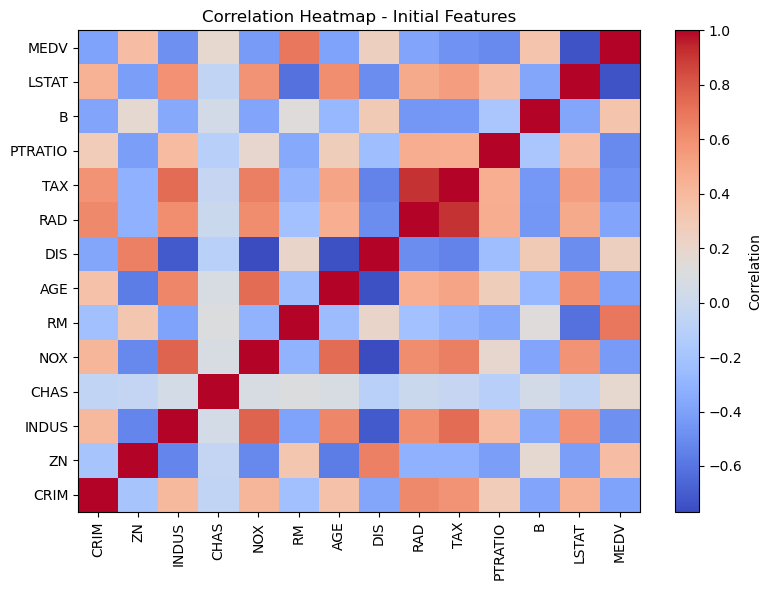

In [37]:
# Step 2.3: Plot correlation heatmap
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr.values, origin="lower", aspect="auto", cmap="coolwarm")

ax.set_xticks(range(corr.shape[1]))
ax.set_yticks(range(corr.shape[0]))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.index)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Correlation")

ax.set_title("Correlation Heatmap - Initial Features")
plt.tight_layout()
plt.show()

out_dir = pathlib.Path("../outputs/figures")
out_dir.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(8, 6))
plt.imshow(corr.values, origin="lower", aspect="auto", cmap="coolwarm")
plt.xticks(range(corr.shape[1]), corr.columns, rotation=90)
plt.yticks(range(corr.shape[0]), corr.index)
plt.colorbar(label="Correlation")
plt.title("Correlation Heatmap - Initial Features")
plt.tight_layout()
plt.savefig(out_dir / "correlation_heatmap_initial.png", dpi=150)
plt.close()


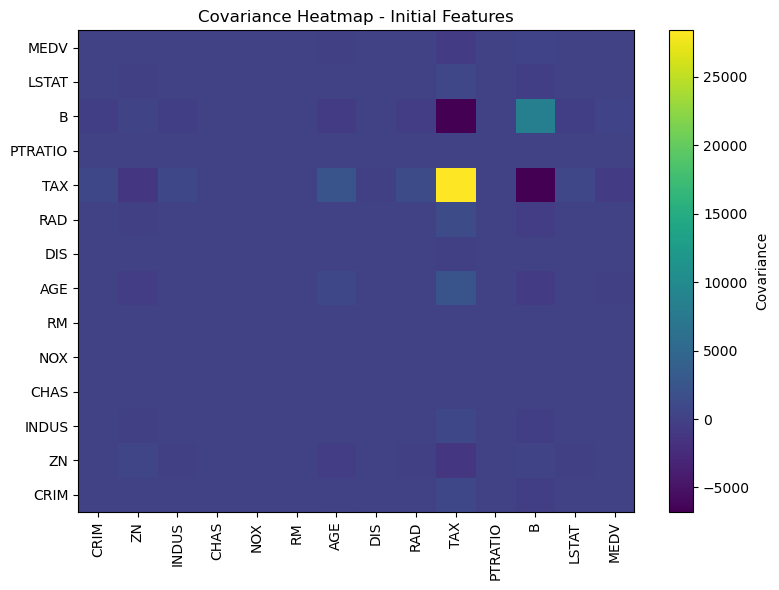

In [38]:
# Step 2.4: Plot covariance heatmap

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cov.values, origin="lower", aspect="auto", cmap="viridis")

ax.set_xticks(range(cov.shape[1]))
ax.set_yticks(range(cov.shape[0]))
ax.set_xticklabels(cov.columns, rotation=90)
ax.set_yticklabels(cov.index)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Covariance")

ax.set_title("Covariance Heatmap - Initial Features")
plt.tight_layout()
plt.show()

# Save covariance heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cov.values, origin="lower", aspect="auto", cmap="viridis")
plt.xticks(range(cov.shape[1]), cov.columns, rotation=90)
plt.yticks(range(cov.shape[0]), cov.index)
plt.colorbar(label="Covariance")
plt.title("Covariance Heatmap - Initial Features")
plt.tight_layout()
plt.savefig(out_dir / "covariance_heatmap_initial.png", dpi=150)
plt.close()


In [39]:
# Step 2.5: Identify highly correlated feature pairs (|r| ≥ 0.7)

threshold = 0.7
pairs = []
cols = corr.columns

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        r = corr.iloc[i, j]
        if pd.notna(r) and abs(r) >= threshold:
            pairs.append((cols[i], cols[j], float(r)))

# Sort pairs by absolute correlation value (descending)
pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)

print("\nHighly correlated feature pairs (|r| ≥ 0.7):")
for a, b, r in pairs_sorted:
    print(f"{a} vs {b}: r = {r:.3f}")


Highly correlated feature pairs (|r| ≥ 0.7):
RAD vs TAX: r = 0.910
NOX vs DIS: r = -0.769
INDUS vs NOX: r = 0.765
AGE vs DIS: r = -0.745
LSTAT vs MEDV: r = -0.736
NOX vs AGE: r = 0.732
INDUS vs TAX: r = 0.731
INDUS vs DIS: r = -0.712


## Step 3 : Feature Extraction with PCA, ICA, and SVD

In [40]:
# Step 3.1: Split X, y and minimal preprocessing (impute + standardize)

assert "MEDV" in df.columns, "Target column 'MEDV' not found."

X = df.drop(columns=["MEDV"]).copy()
y = df["MEDV"].copy()

# Impute numeric columns with median
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

print("X_std shape:", X_std.shape)


X_std shape: (506, 13)


Explained variance ratio (first 10): [0.4629 0.1073 0.0961 0.0669 0.0644 0.0513 0.043  0.0322 0.023  0.0185]
Cumulative explained variance (first 10): [0.4629 0.5702 0.6663 0.7332 0.7977 0.849  0.892  0.9242 0.9471 0.9656]
Chosen number of components (k) for target 95%: 10


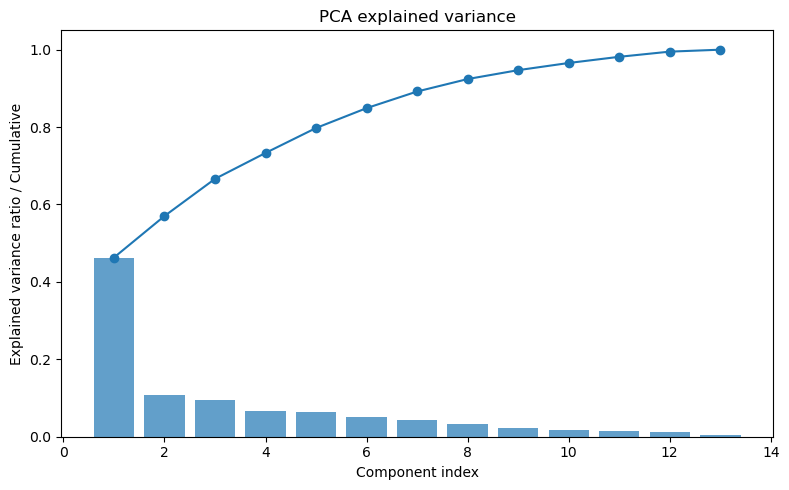

In [41]:
# Step 3.2: PCA - choose number of components via cumulative explained variance

evr_target = 0.95  # you can change to 0.90 or 0.99 if needed
pca_full = PCA(n_components=None, svd_solver="full", random_state=42)
pca_full.fit(X_std)

evr = pca_full.explained_variance_ratio_
evr_cum = np.cumsum(evr)

# choose k as the smallest number reaching the target explained variance
k = int(np.searchsorted(evr_cum, evr_target) + 1)

print("Explained variance ratio (first 10):", np.round(evr[:10], 4))
print("Cumulative explained variance (first 10):", np.round(evr_cum[:10], 4))
print(f"Chosen number of components (k) for target {evr_target*100:.0f}%:", k)

# plot EVR and cumulative EVR
out_dir = Path("../outputs/figures")
out_dir.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(evr)+1), evr, alpha=0.7)
plt.plot(range(1, len(evr)+1), evr_cum, marker="o")
plt.xlabel("Component index")
plt.ylabel("Explained variance ratio / Cumulative")
plt.title("PCA explained variance")
plt.tight_layout()
plt.savefig(out_dir / "pca_explained_variance.png", dpi=150)
plt.show()


In [42]:
# Step 3.3: Build PCA features with k components
pca = PCA(n_components=k, svd_solver="full", random_state=42)
X_pca = pca.fit_transform(X_std)

# wrap into a DataFrame with PC names
pca_cols = [f"PC{i}" for i in range(1, k+1)]
X_pca_df = pd.DataFrame(X_pca, columns=pca_cols)

print("X_pca_df shape:", X_pca_df.shape)
X_pca_df.head()


X_pca_df shape: (506, 10)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-2.120404,0.750813,0.318376,-1.010660,-0.078157,0.325730,0.280080,-0.267260,-0.451921,-0.635464
1,-1.470489,0.550193,-0.721948,-0.358239,0.325249,-0.222532,0.584810,0.222013,-0.103182,-0.235865
2,-2.093771,0.591126,0.141841,-0.317248,1.117537,-0.430719,0.574550,-0.128109,0.087695,0.050882
3,-2.636071,-0.030861,-0.110110,0.118030,1.129994,-0.623217,0.721468,-0.276398,-0.368679,-0.148701
4,-2.215476,0.005867,-0.324865,-0.029148,0.739487,-0.565932,0.888334,0.458033,-0.581599,0.619740


In [43]:
# Step 3.4: Build ICA features using the same k
# Note: ICA does not provide explained variance; we align n_components with PCA for comparability.

try:
    ica = FastICA(n_components=k, whiten="unit-variance", max_iter=1000, tol=1e-4, random_state=42)
except TypeError:
    ica = FastICA(n_components=k, whiten=True, max_iter=1000, tol=1e-4, random_state=42)

X_ica = ica.fit_transform(X_std)
ica_cols = [f"IC{i}" for i in range(1, k+1)]
X_ica_df = pd.DataFrame(X_ica, columns=ica_cols)

print("X_ica_df shape:", X_ica_df.shape)
X_ica_df.head()


X_ica_df shape: (506, 10)


,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10
0,0.388784,-0.065231,-0.453283,0.535792,0.173733,0.442156,0.491334,1.309822,-0.669890,-1.401806
1,0.308609,-0.047751,-1.087216,0.340998,-0.373941,0.405009,0.743406,0.140814,-0.023803,-0.256062
2,0.318489,0.019298,-0.985041,0.155623,-0.424867,1.338001,-0.106146,-0.214756,-0.649159,0.016022
3,0.331137,-0.052910,-1.384250,0.115956,-0.547662,0.780808,-0.190697,-0.719549,-0.802758,-0.893587
4,0.284426,-0.199812,-1.025990,0.052346,-0.585526,1.399761,-0.015523,-1.279242,1.016321,-0.726243


In [44]:
# Step 3.5: Build SVD features using the same k
# TruncatedSVD gives components without centering by default; we already standardized X, which is fine here.

svd = TruncatedSVD(n_components=k, random_state=42)
X_svd = svd.fit_transform(X_std)
svd_cols = [f"SVD{i}" for i in range(1, k+1)]
X_svd_df = pd.DataFrame(X_svd, columns=svd_cols)

print("X_svd_df shape:", X_svd_df.shape)
print("SVD cumulative explained variance (by TruncatedSVD):", np.round(np.cumsum(svd.explained_variance_ratio_), 4))
X_svd_df.head()


X_svd_df shape: (506, 10)
SVD cumulative explained variance (by TruncatedSVD): [0.4629 0.5702 0.6663 0.7332 0.7977 0.849  0.892  0.9242 0.9471 0.9656]


,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10
0,-2.120404,0.750813,0.318376,-1.010660,-0.078157,0.325730,0.280080,-0.267260,-0.451921,-0.635464
1,-1.470489,0.550193,-0.721948,-0.358239,0.325249,-0.222532,0.584810,0.222013,-0.103182,-0.235865
2,-2.093771,0.591126,0.141841,-0.317248,1.117537,-0.430719,0.574550,-0.128109,0.087695,0.050882
3,-2.636071,-0.030861,-0.110110,0.118030,1.129994,-0.623217,0.721468,-0.276398,-0.368679,-0.148701
4,-2.215476,0.005867,-0.324865,-0.029148,0.739487,-0.565932,0.888334,0.458033,-0.581599,0.619740


In [45]:
# Step 3.6: quick sanity checks and saves

# Save EVR table
evr_table = pd.DataFrame({
    "component": [f"PC{i}" for i in range(1, len(evr)+1)],
    "explained_variance_ratio": evr,
    "cumulative_evr": evr_cum
})
tables_dir = Path("../outputs/tables")
tables_dir.mkdir(parents=True, exist_ok=True)
evr_table.to_csv(tables_dir / "pca_evr_table.csv", index=False)


## Step 4: Feature selection with SelectKBest (f_regression) and RFE


In [46]:
# Split X and y
X = df.drop(columns=["MEDV"]).copy()
y = df["MEDV"].copy()

# Step 4.1: Minimal preprocessing (impute + scale)
imputer = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X_imp), columns=X.columns)


In [47]:
# Step 4.2: SelectKBest with f_regression
k = 8  # choose how many top features to keep
kbest = SelectKBest(score_func=f_regression, k=k)
_ = kbest.fit(X_std, y)

kbest_mask = kbest.get_support()
kbest_features = X.columns[kbest_mask]
kbest_scores = pd.Series(kbest.scores_, index=X.columns).sort_values(ascending=False)

print("SelectKBest (top-k features):")
print(kbest_features.tolist())
print("\nSelectKBest scores (sorted):")
print(kbest_scores.round(3))

SelectKBest (top-k features):
['CRIM', 'INDUS', 'NOX', 'RM', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']

SelectKBest scores (sorted):
LSTAT      552.302
RM         471.847
PTRATIO    175.106
INDUS      147.964
TAX        141.761
NOX        112.591
CRIM        87.116
RAD         85.914
AGE         83.797
ZN          76.148
B           63.054
DIS         33.580
CHAS        17.630
dtype: float64


In [48]:
# Step 4.3: RFE with LinearRegression
base_model = LinearRegression()
rfe = RFE(estimator=base_model, n_features_to_select=k, step=1)
_ = rfe.fit(X_std, y)

rfe_mask = rfe.support_
rfe_features = X.columns[rfe_mask]
rfe_ranking = pd.Series(rfe.ranking_, index=X.columns).sort_values()

print("\nRFE (selected features):")
print(rfe_features.tolist())
print("\nRFE ranking (1 = selected):")
print(rfe_ranking)


RFE (selected features):
['CRIM', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']

RFE ranking (1 = selected):
CRIM       1
NOX        1
RM         1
DIS        1
RAD        1
TAX        1
PTRATIO    1
LSTAT      1
ZN         2
B          3
CHAS       4
INDUS      5
AGE        6
dtype: int64


In [49]:
# Step 4.4: Combine and save
out = pd.DataFrame({
    "feature": X.columns,
    "selected_by_kbest": kbest_mask,
    "selected_by_rfe": rfe_mask,
    "kbest_score": kbest.scores_
}).sort_values("kbest_score", ascending=False)

out.to_csv("../outputs/tables/feature_selection_regression.csv", index=False)
print("\nSaved to ../outputs/tables/feature_selection_regression.csv")


Saved to ../outputs/tables/feature_selection_regression.csv


## Step 5: Regression optimization analysis
Models: LinearRegression (analytical) vs SGDRegressor (gradient-based)

In [50]:
# 5.1 Prepare data (imputation + standardization)
X_raw = df.drop(columns=["MEDV"]).copy()
y = df["MEDV"].values

imputer = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imputer.fit_transform(X_raw), columns=X_raw.columns)

scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X_imp), columns=X_imp.columns)

In [51]:
# 5.2 Create PCA-transformed data (95% explained variance)
pca = PCA(n_components=0.95, svd_solver="full", random_state=42)
X_pca = pd.DataFrame(pca.fit_transform(X_std), columns=[f"PC{i}" for i in range(1, pca.n_components_+1)])

In [52]:
# 5.3 Build Selected space (prefer RFE list; else KBest; else fallback KBest top-8)
if "rfe_features" in globals():
    selected_cols = list(rfe_features)
elif "kbest_features" in globals():
    selected_cols = list(kbest_features)
else:
    sel = SelectKBest(score_func=f_regression, k=min(8, X_std.shape[1]))
    sel.fit(X_std, y)
    selected_cols = X_std.columns[sel.get_support()].tolist()

X_sel = X_std[selected_cols].copy()

In [53]:
# 5.4 Unified train/test split for all spaces
def split_like(X):
    return train_test_split(X, y, test_size=0.2, random_state=42)

splits = {
    "original": split_like(X_std.values),
    "pca":      split_like(X_pca.values),
    "selected": split_like(X_sel.values),
}


In [54]:
# 5.5 Model 1: LinearRegression (analytical) on all spaces

lin_rows = []
for name, (X_tr, X_te, y_tr, y_te) in splits.items():
    model = LinearRegression()
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    coef = model.coef_
    lin_rows.append({
        "space":          name,
        "rmse":           float(root_mean_squared_error(y_te, y_pred)),
        "r2":             float(r2_score(y_te, y_pred)),
        "mean_abs_coef":  float(np.mean(np.abs(coef))),
        "max_abs_coef":   float(np.max(np.abs(coef))),
        "n_features":     int(X_tr.shape[1]),
    })

lin_df_6 = pd.DataFrame(lin_rows).set_index("space").sort_index()

print("\n[LinearRegression] Coefficient stability (lower is better):")
print(lin_df_6[["mean_abs_coef", "max_abs_coef", "n_features"]].round(4))

print("\n[LinearRegression] Performance (RMSE, R2):")
print(lin_df_6[["rmse", "r2"]].round(6))



[LinearRegression] Coefficient stability (lower is better):
          mean_abs_coef  max_abs_coef  n_features
space                                            
original         1.6148        3.3111          13
pca              1.2573        3.3191          10
selected         2.2933        3.5368           8

[LinearRegression] Performance (RMSE, R2):
              rmse        r2
space                       
original  4.999938  0.659101
pca       5.399750  0.602403
selected  4.948429  0.666089


In [55]:
# 5.6 Model 2: SGDRegressor (gradient-based) on all spaces
# 5.6.2 Fit on each feature space and evaluate
sgd_rows = []
for name, (X_tr, X_te, y_tr, y_te) in splits.items():
    sgd = SGDRegressor(
        loss="squared_error",
        random_state=42,
        max_iter=5000,
        tol=1e-5
    )
    sgd.fit(X_tr, y_tr)
    y_pred = sgd.predict(X_te)

    rmse = root_mean_squared_error(y_te, y_pred)
    r2 = r2_score(y_te, y_pred)

    sgd_rows.append({
        "space": name,
        "rmse": float(rmse),
        "r2": float(r2),
        "n_iter_": int(sgd.n_iter_)
    })

# 5.6.3 Summaries
sgd_df = pd.DataFrame(sgd_rows).set_index("space").sort_index()

print("\n[SGDRegressor] Final RMSE, R2, and iterations:")
print(sgd_df.round(4))



[SGDRegressor] Final RMSE, R2, and iterations:
            rmse      r2  n_iter_
space                            
original  5.0652  0.6501       30
pca       5.3866  0.6043       17
selected  5.0066  0.6582       30


In [56]:
Xo_train, Xo_test, yo_train, yo_test = splits["original"]
Xp_train, Xp_test, yp_train, yp_test = splits["pca"]

curve_orig = sgd_convergence(Xo_train, yo_train, Xo_test, yo_test)
curve_pca  = sgd_convergence(Xp_train, yp_train, Xp_test, yp_test)

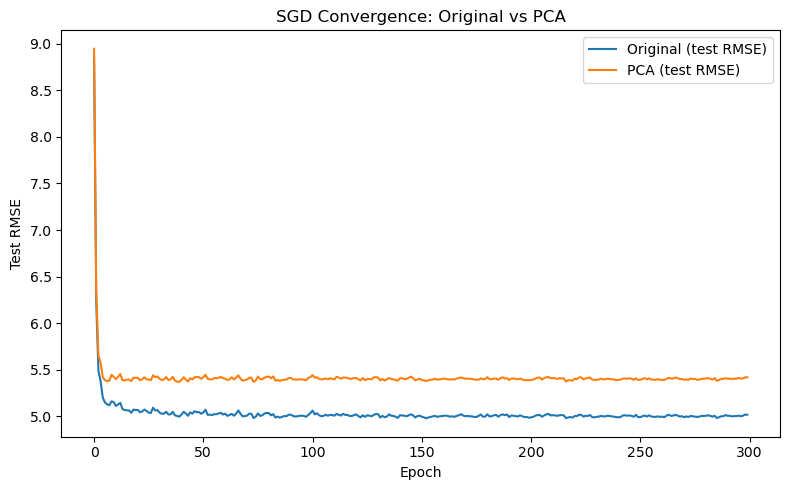


Saved figure: ../outputs/figures/sgd_convergence_original_vs_pca.png


In [57]:
# 5.7 Convergence curves (test RMSE) for all 3 spaces

def sgd_convergence(X_train, y_train, X_test, y_test, max_epochs=300, eta0=0.01):
    sgd = SGDRegressor(
        loss="squared_error", penalty="l2",
        learning_rate="invscaling", eta0=eta0,
        alpha=1e-4, random_state=42,
        max_iter=1, tol=None
    )
    rmse_curve = []
    prev = None
    for epoch in range(max_epochs):
        X_sh, y_sh = shuffle(X_train, y_train, random_state=epoch)
        sgd.partial_fit(X_sh, y_sh)
        y_pred = sgd.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        rmse_curve.append(rmse)
        if prev is not None and abs(prev - rmse) < 1e-5:
            break
        prev = rmse
    return np.array(rmse_curve)

curve_orig = sgd_convergence(Xo_train, yo_train, Xo_test, yo_test)
curve_pca = sgd_convergence(Xp_train, yp_train, Xp_test, yp_test)

out_dir = Path("../outputs/figures")
out_dir.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(8,5))
plt.plot(curve_orig, label="Original (test RMSE)")
plt.plot(curve_pca, label="PCA (test RMSE)")
plt.xlabel("Epoch")
plt.ylabel("Test RMSE")
plt.title("SGD Convergence: Original vs PCA")
plt.legend()
plt.tight_layout()
plt.savefig(out_dir / "sgd_convergence_original_vs_pca.png", dpi=150)
plt.show()

print("\nSaved figure: ../outputs/figures/sgd_convergence_original_vs_pca.png")

## Step6: Visualization and Value Summary


=== LinearRegression Summary ===
              rmse        r2  mean_abs_coef  max_abs_coef  n_features
space                                                                
original  4.999938  0.659101       1.614813      3.311067          13
pca       5.399750  0.602403       1.257348      3.319135          10
selected  4.948429  0.666089       2.293320      3.536817           8

=== SGDRegressor Summary ===
              rmse        r2  n_iter_
space                                
original  5.065228  0.650140       30
pca       5.386639  0.604331       17
selected  5.006617  0.658190       30


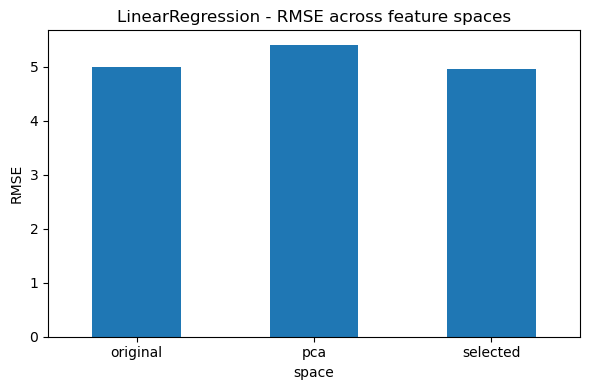

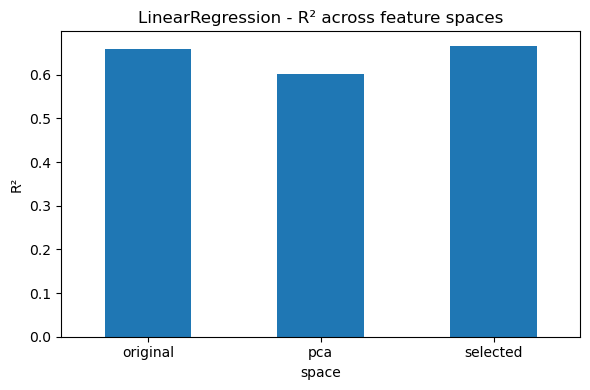

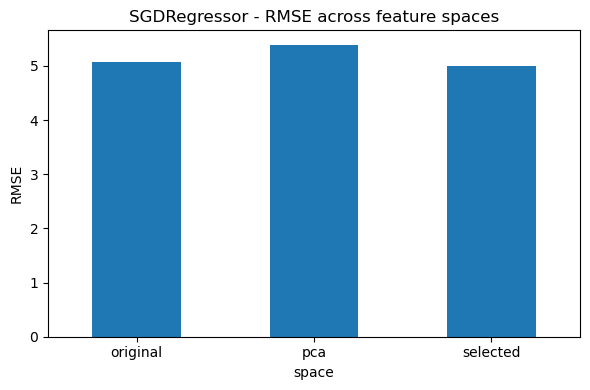

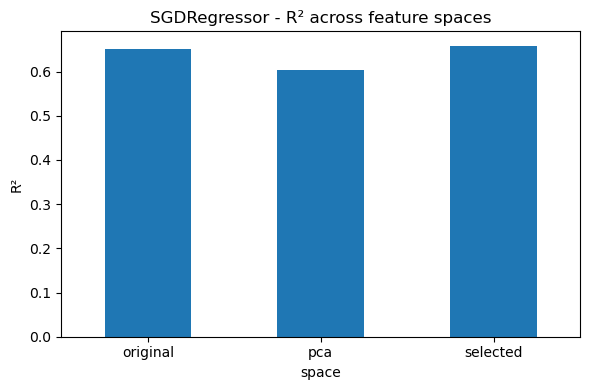


Saved figures to: ../outputs/figures


In [58]:
save_dir = Path(OUT_DIR) if "OUT_DIR" in globals() else Path("../outputs/figures")
save_dir.mkdir(parents=True, exist_ok=True)

# Print numeric summaries
print("\n=== LinearRegression Summary ===")
print(lin_df_6[["rmse", "r2", "mean_abs_coef", "max_abs_coef", "n_features"]])

print("\n=== SGDRegressor Summary ===")
print(sgd_df[["rmse", "r2", "n_iter_"]])

# Plot RMSE for LinearRegression
plt.figure(figsize=(6, 4))
lin_df_6["rmse"].plot(kind="bar", rot=0)
plt.ylabel("RMSE")
plt.title("LinearRegression - RMSE across feature spaces")
plt.tight_layout()
plt.savefig(save_dir / "step6_linear_rmse.png", dpi=150)
plt.show()

# Plot R2 for LinearRegression
plt.figure(figsize=(6, 4))
lin_df_6["r2"].plot(kind="bar", rot=0)
plt.ylabel("R²")
plt.title("LinearRegression - R² across feature spaces")
plt.tight_layout()
plt.savefig(save_dir / "step6_linear_r2.png", dpi=150)
plt.show()

# Plot RMSE for SGDRegressor
plt.figure(figsize=(6, 4))
sgd_df["rmse"].plot(kind="bar", rot=0)
plt.ylabel("RMSE")
plt.title("SGDRegressor - RMSE across feature spaces")
plt.tight_layout()
plt.savefig(save_dir / "step6_sgd_rmse.png", dpi=150)
plt.show()

# Plot R2 for SGDRegressor
plt.figure(figsize=(6, 4))
sgd_df["r2"].plot(kind="bar", rot=0)
plt.ylabel("R²")
plt.title("SGDRegressor - R² across feature spaces")
plt.tight_layout()
plt.savefig(save_dir / "step6_sgd_r2.png", dpi=150)
plt.show()


# 6.8 Done
print("\nSaved figures to:", str(save_dir))
